# Load packages and set global settings 

Imports and set up paths for output data and raw data. Doing settings for scanpy plottings. Set whether the anndata object and 48TF matrix are recomputed or load from existed files.

In [1]:
import anndata
import numpy as np
import scanpy as sc
import sys
import pandas as pd
import seaborn as sb
import scipy
import matplotlib.pyplot as plt
import types
import os
import celltypist
from celltypist import models
import pickle

print(sc.__version__)
print(anndata.__version__)

np.random.seed(seed=42)

1.10.3
0.10.9


In [2]:
# create backports module
if 'backports' not in sys.modules:
    backports_module = types.ModuleType('backports')
    backports_module.__version__ = "1.0"
    sys.modules['backports'] = backports_module

# print version info
sc.logging.print_versions()

-----
anndata     0.10.9
scanpy      1.10.3
-----
PIL                         11.3.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        25.3.0
attrs                       25.3.0
babel                       2.17.0
backports                   1.0
brotli                      1.0.9
celltypist                  1.7.1
certifi                     2025.08.03
charset_normalizer          3.4.3
colorama                    0.4.6
comm                        0.2.3
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.9.0.post0
debugpy                     1.8.16
decorator                   5.2.1
defusedxml                  0.7.1
exceptiongroup              1.3.0
executing                   2.2.0
fastjsonschema              NA
fqdn                        NA
h5py                        3.14.0
idna                        3.10
igraph                      0.11.9
importlib_resources         NA


In [3]:
# current working dir
root_dir = './'

# set output paths
results_dir = root_dir + 'results/'
dir_out = results_dir + 'figures/'
dir_anndata = results_dir + 'anndata/'
dir_tfmatrix = results_dir + 'csv/'
dir_model = results_dir + 'model/'

# create required output dirs
os.makedirs(root_dir + 'results/', exist_ok=True)
os.makedirs(results_dir + 'figures/', exist_ok=True)
os.makedirs(results_dir + 'anndata/', exist_ok=True)
os.makedirs(results_dir + 'csv/', exist_ok=True)
os.makedirs(results_dir + 'model/', exist_ok=True)

# set paths for the raw dataset
arrayed_h5ad = "./raw_data/sc_divergentDC.48TF_Arrayed.h5ad"
arrayed_csv = "./raw_data/brd_divergentDC.48TF_Arrayed.csv"

In [4]:
# scanpy plotting settings
sc.settings.set_figure_params(dpi=80, dpi_save=600, scanpy=True)
sc.settings.figdir = dir_out

In [5]:
# set whether anndata object and 48TF matrix are recomputed or loaded from existed files
bool_recomp = True

# Quality control

Quality control on cells. Doing filtering based on 'nFeature_RNA', 'nCount_RNA' and 'percent.mt'to retain cells with sufficient gene numbers and counts and low mitochondrial content.

In [6]:
# read raw data
adata_raw = sc.read_h5ad(arrayed_h5ad)
csv_data_raw = pd.read_csv(arrayed_csv, index_col=0)

... storing 'orig.ident' as categorical
... storing 'Cell_Type_Experimental' as categorical
... storing 'Type' as categorical
... storing 'Tech.Rep' as categorical
... storing 'Seq.Run' as categorical
... storing 'Sort' as categorical


raw cell and gene numbers: 41616 cells, 36745 genes
min nFeature_RNA: 3993 max nFeature_RNA: 9107
min nCount_RNA: 15107.0 max nCount_RNA: 77594.0
min mt: 0.7146001964303857 max mt: 21.045020120724345

Quantiles for nFeature_RNA, nCount_RNA and percent.mt
0.25    6593.0
0.50    7212.0
0.75    7726.0
0.95    8324.0
Name: nFeature_RNA, dtype: float64
0.25    37187.75
0.50    46390.00
0.75    55963.25
0.95    68961.25
Name: nCount_RNA, dtype: float64
0.25     8.585247
0.50     9.886924
0.75    11.405051
0.95    14.953122
Name: percent.mt, dtype: float64


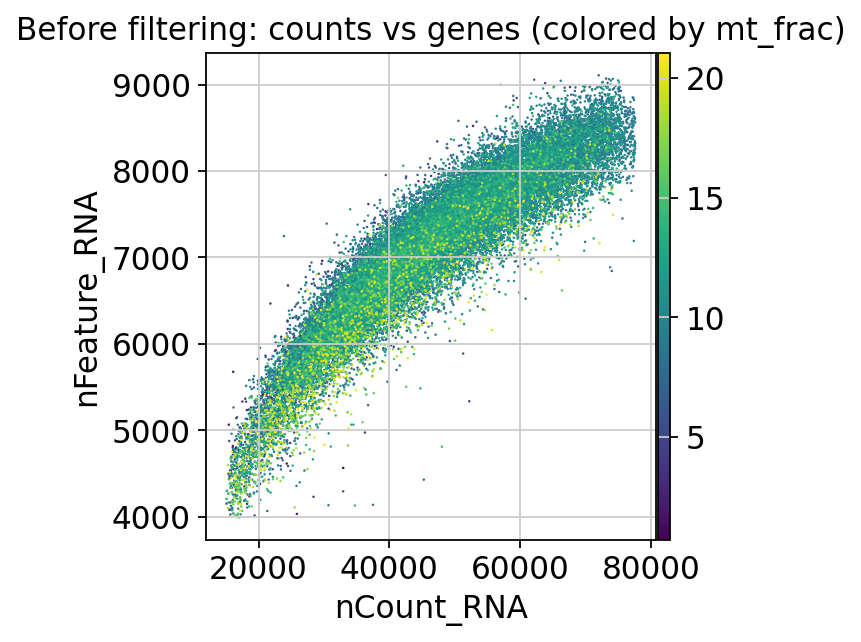

In [7]:
# basic inspections for raw data

# cell and gene numbers before filtering
print(f"raw cell and gene numbers: {adata_raw.n_obs} cells, {adata_raw.n_vars} genes")

# min and max for nFeature_RNA, nCount_RNA and mt percentage before filtering
print("min nFeature_RNA:", adata_raw.obs['nFeature_RNA'].min(), "max nFeature_RNA:", adata_raw.obs['nFeature_RNA'].max())
print("min nCount_RNA:", adata_raw.obs['nCount_RNA'].min(), "max nCount_RNA:", adata_raw.obs['nCount_RNA'].max())
print("min mt:", adata_raw.obs['percent.mt'].min(), "max mt:", adata_raw.obs['percent.mt'].max())

# quantiles
print("\nQuantiles for nFeature_RNA, nCount_RNA and percent.mt")
print(adata_raw.obs['nFeature_RNA'].quantile([0.25, 0.5, 0.75, 0.95]))
print(adata_raw.obs['nCount_RNA'].quantile([0.25, 0.5, 0.75, 0.95]))
print(adata_raw.obs['percent.mt'].quantile([0.25, 0.5, 0.75, 0.95]))

# scatter plot before filtering
sc.pl.scatter(adata_raw, x='nCount_RNA', y='nFeature_RNA', color='percent.mt', size=5, title='Before filtering: counts vs genes (colored by mt_frac)')
plt.show()

cell numbers after QC: 37201 cells, and 4415 have been filtered


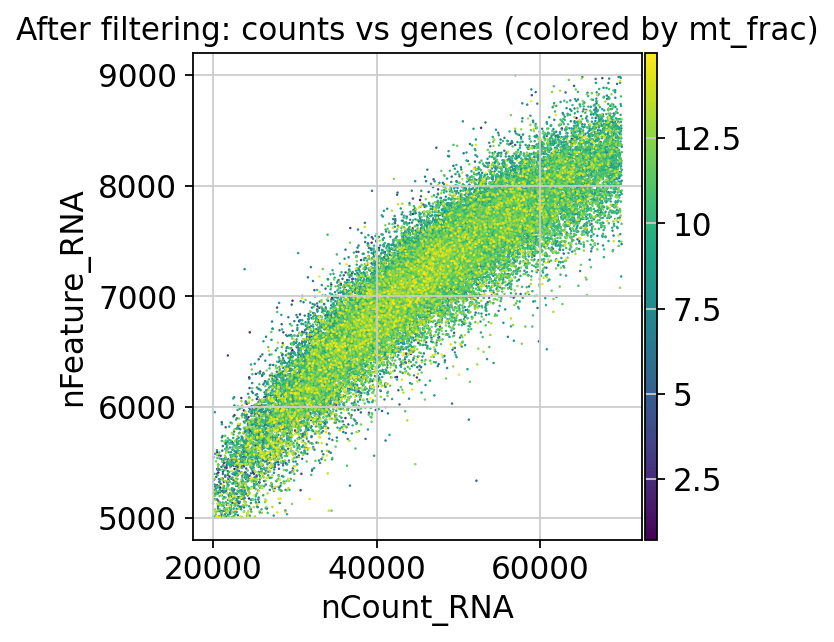

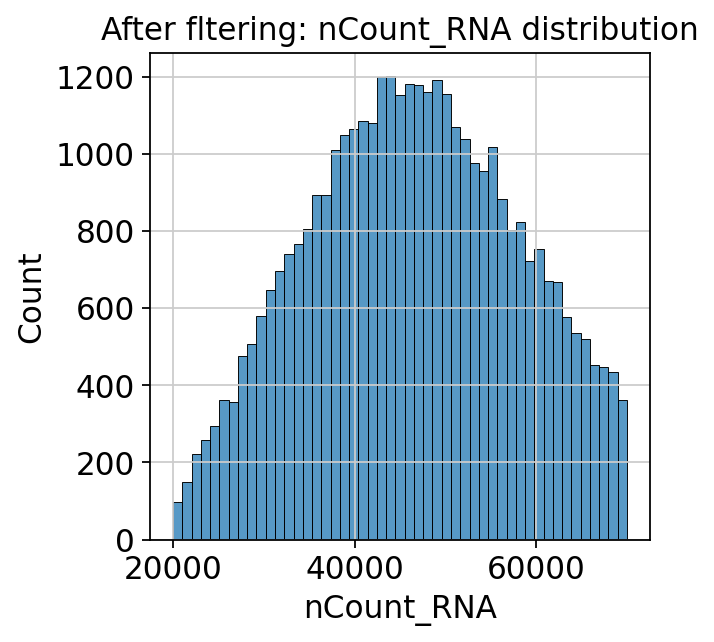

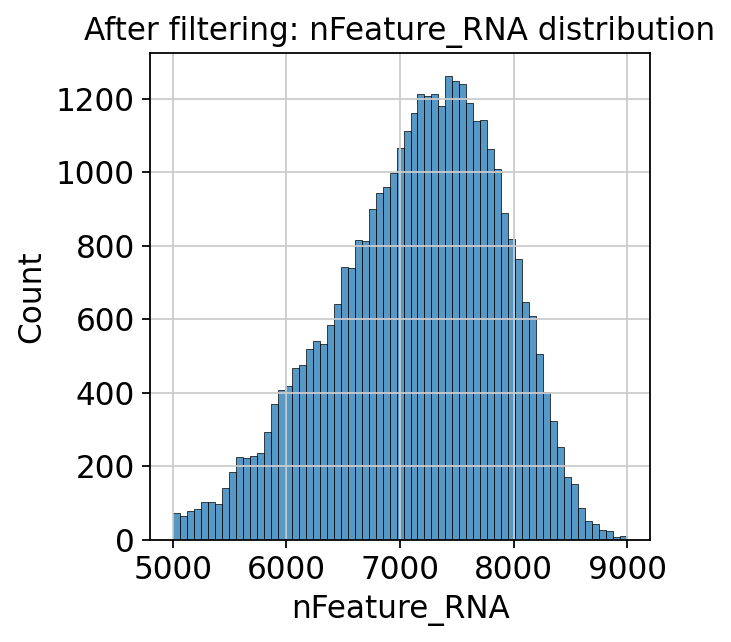

In [8]:
# cell filtering with nFeature_RNA, nCount_RNA and percent.mt

adata_qc = adata_raw[
    (adata_raw.obs['nFeature_RNA'] > 5000) &      
    (adata_raw.obs['nFeature_RNA'] < 9000) &    
    (adata_raw.obs['nCount_RNA'] > 20000) & 
    (adata_raw.obs['nCount_RNA'] < 70000) & 
    (adata_raw.obs['percent.mt'] < 15)           
]
print(f"cell numbers after QC: {adata_qc.n_obs} cells, and {adata_raw.n_obs - adata_qc.n_obs} have been filtered")

# plots after filtering
sc.pl.scatter(adata_qc, x='nCount_RNA', y='nFeature_RNA', color='percent.mt', size=5, title='After filtering: counts vs genes (colored by mt_frac)')
plt.show()
sb.histplot(data=adata_qc.obs, x='nCount_RNA', kde=False).set_title('After fltering: nCount_RNA distribution')
plt.show()
sb.histplot(data=adata_qc.obs, x='nFeature_RNA', kde=False).set_title('After filtering: nFeature_RNA distribution')
plt.show()

In [9]:
# remove these cells that have been filtered from h5ad file in csv file as well based on cell ids

valid_cell_ids = adata_qc.obs.index.tolist()
csv_qc = csv_data_raw.loc[valid_cell_ids]

# Normalization

Normalization and log transformation to correct for differences in sequencing depth across cells and make the data more normally distributed and suitable for downstream analysis.

In [10]:
# normalization and log convertion
sc.pp.normalize_total(adata_qc, target_sum=1e4)
sc.pp.log1p(adata_qc)

In [11]:
size_factors = adata_qc.obs["nCount_RNA"]/np.mean(adata_qc.obs["nCount_RNA"])
csv_nor = csv_qc.div(size_factors, axis=0)
csv_log = np.log1p(csv_nor)

In [12]:
print(adata_qc.X)
print(csv_log)

  (np.int32(0), np.int32(1))	0.47904229986566293
  (np.int32(0), np.int32(12))	0.3433662413188894
  (np.int32(0), np.int32(13))	0.18634883319887136
  (np.int32(0), np.int32(22))	0.3433662413188894
  (np.int32(0), np.int32(23))	0.970301458149937
  (np.int32(0), np.int32(24))	0.18634883319887136
  (np.int32(0), np.int32(25))	0.8015776646056579
  (np.int32(0), np.int32(27))	0.3433662413188894
  (np.int32(0), np.int32(29))	0.3433662413188894
  (np.int32(0), np.int32(33))	0.5984902348506373
  (np.int32(0), np.int32(36))	0.18634883319887136
  (np.int32(0), np.int32(53))	0.7051806770859705
  (np.int32(0), np.int32(54))	0.18634883319887136
  (np.int32(0), np.int32(59))	0.18634883319887136
  (np.int32(0), np.int32(60))	0.18634883319887136
  (np.int32(0), np.int32(62))	0.5984902348506373
  (np.int32(0), np.int32(70))	0.18634883319887136
  (np.int32(0), np.int32(76))	0.3433662413188894
  (np.int32(0), np.int32(79))	0.3433662413188894
  (np.int32(0), np.int32(80))	0.18634883319887136
  (np.int32(0

In [13]:
# save the anndata object and 48TF matrix after cell QC, normalization and logarithmized
adata_qc_nor_log_path = dir_anndata + 'adata_qc_nor_log.h5ad'
tfmatrix_nor_log_path = dir_tfmatrix + 'tfmatrix_nor_log.csv'

if adata_qc.raw is not None:

    raw_X = adata_qc.raw.X
    raw_var = adata_qc.raw.var.copy()
    
    if '_index' in raw_var.columns:
        raw_var = raw_var.drop(columns=['_index'])
    
    adata_qc.raw = sc.AnnData(
        X=raw_X,
        var=raw_var,
        obs=adata_qc.obs
    )
if not os.path.exists(adata_qc_nor_log_path) or bool_recomp == True:
    adata_qc.write_h5ad(adata_qc_nor_log_path)
    print(f"AnnData object saved to: {adata_qc_nor_log_path}")
if not os.path.exists(tfmatrix_nor_log_path) or bool_recomp == True:
    csv_log.to_csv(tfmatrix_nor_log_path, index=True)
    print(f"48TF matrix saved to: {tfmatrix_nor_log_path}")

AnnData object saved to: ./results/anndata/adata_qc_nor_log.h5ad
48TF matrix saved to: ./results/csv/tfmatrix_nor_log.csv


In [14]:
adata_qc_nor_log_path = dir_anndata + 'adata_qc_nor_log.h5ad'
tfmatrix_nor_log_path = dir_tfmatrix + 'tfmatrix_nor_log.csv'

if bool_recomp == False:
    adata_qc = sc.read_h5ad(adata_qc_nor_log_path)
    print(f"AnnData reloaded: {adata_qc.shape}")
    csv_log = pd.read_csv(tfmatrix_nor_log_path, index_col=0)
    print(f"TF matrix reloaded: {csv_log.shape}")

In [15]:
print(csv_log)

                NFIL3  MYCL  FOXN2      RBPJ      ETS1     NR4A1    ARID3A  \
D2_3281      0.000000   0.0    0.0  2.725485  0.000000  1.348790  0.000000   
D2_29811     0.000000   0.0    0.0  0.000000  0.000000  1.430070  0.000000   
D2_41722     0.000000   0.0    0.0  0.000000  0.000000  0.000000  0.000000   
D2_45022     0.000000   0.0    0.0  0.000000  0.000000  0.000000  0.000000   
D2_54128     1.804675   0.0    0.0  2.959109  1.804675  2.092999  0.000000   
...               ...   ...    ...       ...       ...       ...       ...   
SP_56587192  1.045434   0.0    0.0  2.490541  1.045434  2.125673  4.839729   
SP_56588334  0.000000   0.0    0.0  2.625237  1.142515  0.000000  0.000000   
SP_56592018  0.000000   0.0    0.0  3.723869  0.000000  0.000000  1.140265   
SP_56596113  0.000000   0.0    0.0  2.083824  1.338693  1.652705  4.707258   
SP_56605294  0.000000   0.0    0.0  0.000000  0.000000  1.281418  0.000000   

                 BCL6  JUNB   TSC22D3  ...    ZBTB46       ID2 

# Features and labels preparation

Creat features and labels for machine learning classification model input based on celltypist. Celltypist assign cell identities based on gene expression levels and also provide probabilities for each cell type prediction. We filter those cells ('discard') which haven't clear cell identites (top1 probability<90%), and consider those cells with both high value(>=90%) for top1 and top2 cell type probability as 'collision', which means they encounter cell identity conflicts after cell reprogramming. Cell identities are the labels and related 48 TFs' expression levels are features.

In [16]:
# Download models for celltypist
models.download_models()

📂 Storing models in /home/inf-48-2024/.celltypist/data/models
⏩ Skipping [1/58]: Immune_All_Low.pkl (file exists)
⏩ Skipping [2/58]: Immune_All_High.pkl (file exists)
⏩ Skipping [3/58]: Adult_COVID19_PBMC.pkl (file exists)
⏩ Skipping [4/58]: Adult_CynomolgusMacaque_Hippocampus.pkl (file exists)
⏩ Skipping [5/58]: Adult_Human_MTG.pkl (file exists)
⏩ Skipping [6/58]: Adult_Human_PancreaticIslet.pkl (file exists)
⏩ Skipping [7/58]: Adult_Human_PrefrontalCortex.pkl (file exists)
⏩ Skipping [8/58]: Adult_Human_Skin.pkl (file exists)
⏩ Skipping [9/58]: Adult_Human_Vascular.pkl (file exists)
⏩ Skipping [10/58]: Adult_Mouse_Gut.pkl (file exists)
⏩ Skipping [11/58]: Adult_Mouse_OlfactoryBulb.pkl (file exists)
⏩ Skipping [12/58]: Adult_Pig_Hippocampus.pkl (file exists)
⏩ Skipping [13/58]: Adult_RhesusMacaque_Hippocampus.pkl (file exists)
⏩ Skipping [14/58]: Adult_cHSPCs_Illumina.pkl (file exists)
⏩ Skipping [15/58]: Adult_cHSPCs_Ultima.pkl (file exists)
⏩ Skipping [16/58]: Autopsy_COVID19_Lung.p

In [17]:
# assign cell identities based on celltypist
model = models.Model.load(model = 'Immune_All_High.pkl')
predictions = celltypist.annotate(
    adata_qc, 
    model=model,
    majority_voting=False
)

🔬 Input data has 37201 cells and 36745 genes
🔗 Matching reference genes in the model
🧬 5611 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


In [18]:
# get the probabilities of cell type predictions 
prob_matrix_df = predictions.probability_matrix
prob_matrix = prob_matrix_df.values 
sorted_probs = np.sort(prob_matrix, axis=1)

top1_prob = sorted_probs[:, -1] 
top2_prob = sorted_probs[:, -2]

# get the top1 probability's corresponding cell type name
top1_labels = prob_matrix_df.idxmax(axis=1).values

# define thresholds
T1 = 0.9 # threshold for distinguishing 'discard' cells 
T2 = 0.9 # threshold for distinguishing 'collision' cells

# define conditions and corresponding results for assigning cell types
conditions = [
    (top1_prob >= T1) & (top2_prob >= T2),   
    (top1_prob >= T1) & (top2_prob < T2)    
]
choices = [
    'Collision',    # top1 probability>0.9 & top2 probability>0.9
    top1_labels     # top1 probability>0.9 & top2 probability<0.9
    # 'discard': top1 probability<0.9
]

# assign cell types and add to adata
final_labels = np.select(conditions, choices, default='Discard')
adata_qc.obs['assignment_z'] = pd.Series(final_labels, index=adata_qc.obs.index)

print("Tag assignment complete!")
print(f" New Tag Statistics (Before Filtering):\n{adata_qc.obs['assignment_z'].value_counts()}")

# filter "discard" cells with low probability for every cell type
mask_discard = (adata_qc.obs['assignment_z'] != 'Discard')
adata_intermediate = adata_qc[mask_discard, :].copy() 
print(f"  Remove {adata_qc.n_obs - adata_intermediate.n_obs} 'Discard' cells.")

# filter cells with counts<50
min_count = 50
value_counts = adata_intermediate.obs['assignment_z'].value_counts()
labels_to_keep = value_counts[value_counts >= min_count].index.tolist()

print(f"\n Cell types to keep: (>= {min_count})")
print(value_counts[value_counts >= min_count])

mask_min_count = adata_intermediate.obs['assignment_z'].isin(labels_to_keep)
adata_assigned = adata_intermediate[mask_min_count, :].copy()

print(f"\n  Original cell count (adata_qc): {adata_qc.n_obs}")
print(f"  Cell count after filtering (adata_assigned): {adata_assigned.n_obs}")
print(f"  (Remove {adata_qc.n_obs - adata_assigned.n_obs} 'Discard' or rare cells)")

Tag assignment complete!
 New Tag Statistics (Before Filtering):
assignment_z
Fibroblasts          11565
Discard              10351
Collision            10235
Macrophages           4669
Epithelial cells       121
DC                     113
ILC                     61
B cells                 25
T cells                 21
Endothelial cells       17
Cycling cells           12
Monocytes                4
Erythroid                3
Mast cells               3
DC precursor             1
Name: count, dtype: int64
  Remove 10351 'Discard' cells.

 Cell types to keep: (>= 50)
assignment_z
Fibroblasts         11565
Collision           10235
Macrophages          4669
Epithelial cells      121
DC                    113
ILC                    61
Name: count, dtype: int64

  Original cell count (adata_qc): 37201
  Cell count after filtering (adata_assigned): 26764
  (Remove 10437 'Discard' or rare cells)


In [19]:
valid_cell_id = adata_assigned.obs.index.tolist()
csv_assigned_filter = csv_log.loc[valid_cell_id]

In [20]:
# save the anndata object and 48TF matrix after cell QC, normalization and logarithmized, and assigning cell identities
adata_assigned_filtered_path = dir_anndata + 'adata_assigned_filtered.h5ad'
tfmatrix_assigned_filtered_path = dir_tfmatrix + 'tfmatrix_assigned_filtered.csv'

if adata_assigned.raw is not None:

    raw_X = adata_assigned.raw.X
    raw_var = adata_assigned.raw.var.copy()
    
    if '_index' in raw_var.columns:
        raw_var = raw_var.drop(columns=['_index'])
    
    adata_assigned.raw = sc.AnnData(
        X=raw_X,
        var=raw_var,
        obs=adata_assigned.obs
    )
if not os.path.exists(adata_assigned_filtered_path) or bool_recomp == True:
    adata_assigned.write_h5ad(adata_assigned_filtered_path)
    print(f"AnnData object saved to: {adata_assigned_filtered_path}")
if not os.path.exists(tfmatrix_assigned_filtered_path) or bool_recomp == True:
    csv_assigned_filter.to_csv(tfmatrix_assigned_filtered_path, index=True)
    print(f"48TF matrix saved to: {tfmatrix_assigned_filtered_path}")

... storing 'assignment_z' as categorical


AnnData object saved to: ./results/anndata/adata_assigned_filtered.h5ad
48TF matrix saved to: ./results/csv/tfmatrix_assigned_filtered.csv
